### 생선 분류 - 최적의 K찾기 : 하이퍼파라미터
- 데이터셋 : fish.csv
- 피쳐/특성 : Weight, Lenght
- 타겟/라벨 : Species
- 학습방법 : 지도학습 => 분류
- 학습알고리즘: 최근접이웃알고리즘
- 하이퍼파라미터 튜닝 : 모델 성능 개선

[1] 데이터 준비

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
DATA_FILE = '../data/fish.csv'

In [86]:
# 행 : Bream, Smelt, 컬럼: Species, Weight, Height => 0, 1, ,2
fishDF = pd.read_csv(DATA_FILE, usecols=[0,1,2])
fishDF.head(3)

,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5


In [87]:
mask = (fishDF['Species'] == 'Bream') | (fishDF['Species'] == 'Smelt')
twoDF = fishDF[mask]
twoDF.reset_index(drop=True, inplace=True)

In [88]:
# Species 컬럼을 수치화 => Bream 0, Smelt 1
twoDF.loc[:,'Code']=twoDF['Species'].replace({'Bream':0, 'Smelt':1})

C:\Users\KDP15\AppData\Local\Temp\ipykernel_9792\3376092970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoDF.loc[:,'Code']=twoDF['Species'].replace({'Bream':0, 'Smelt':1})


[2] 피쳐와 타겟 분리

In [89]:
features=twoDF[['Weight', 'Length']]
target=twoDF['Code']

print(f'features => {features.shape}, {features.ndim}D')
print(f'target => {target.shape}, {target.ndim}D')

features => (49, 2), 2D
target => (49,), 1D


[3] 데이터셋 준비 => 학습용, 테스트용

In [90]:
from sklearn.model_selection import train_test_split

In [91]:
# train:test = 80:20 ==> test_size = 0.2 또는 train_size = 0.8
# stratify 매개변수 : 분류일 경우 사용, 분류 타겟의 종류에 대한 비율 고려
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=10)

In [92]:
# train:test = 80:20 체크
print(f'X_train : {X_train.shape}, {X_train.ndim}D')
print(f'y_train : {y_train.shape}, {y_train.ndim}D')
print(f'X_test : {X_test.shape}, {X_test.ndim}D')
print(f'y_test : {y_test.shape}, {y_test.ndim}D')

X_train : (39, 2), 2D
y_train : (39,), 1D
X_test : (10, 2), 2D
y_test : (10,), 1D


In [93]:
# target 0(Bream), 1(Smelt)의 비율
y_train.value_counts()[0]/y_train.shape[0],  y_train.value_counts()[1]/y_train.shape[0]

(0.717948717948718, 0.28205128205128205)

In [94]:
y_test.value_counts()[0]/y_test.shape[0], y_test.value_counts()[1]/y_test.shape[0]

(0.7, 0.3)

[3-2] 피쳐 스케일링

In [95]:
from sklearn.preprocessing import MinMaxScaler

In [96]:
# 스케일러 인스턴스 생성
mmScaler = MinMaxScaler()

In [97]:
# 데이터에 기반한 MinMaxScaler 동작을 위한 학습 진행
mmScaler.fit(X_train)

MinMaxScaler()

In [98]:
mmScaler.min_, mmScaler.data_min_, mmScaler.scale_, mmScaler.data_max_

(array([-0.00674519, -0.31410256]),
 array([6.7, 9.8]),
 array([0.00100675, 0.03205128]),
 array([1000.,   41.]))

In [99]:
# 학습용 데이터 ==> 스케일링 ==> ndarray 타입 반환
X_train_scaled=mmScaler.transform(X_train)
X_train_scaled.shape, X_train_scaled.min(), X_train_scaled.max()

((39, 2), 0.0, 1.0000000000000002)

In [100]:
# 테스트용 데이터 ==> 스케일링  ==> ndarray 타입 반환
X_test_scaled=mmScaler.transform(X_test)
X_test_scaled.shape, X_test_scaled.min(), X_test_scaled.max()

((10, 2), 0.0033222591362126247, 0.8489882210812445)

[4] 훈련/학습 진행
- 학습 알고리즘 인스턴스 생성
- 학습 진행 => fit()

In [101]:
from sklearn.neighbors import KNeighborsClassifier

In [102]:
# 인스턴스 생성
model = KNeighborsClassifier()

In [103]:
# 학습 진행 ===> 학습용 데이터셋
model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [104]:
# 학습 후 모델 파라미터
model.classes_ ,  model.n_samples_fit_

(array([0, 1], dtype=int64), 39)

[5] 모델 성능평가 ==> score() 메서드   + 테스트 데이터셋

In [105]:
model.score(X_test_scaled, y_test)

1.0

[6] 최적의 k 개수 찾기 ==> 모델의 성능 영향 미치는 파라미터
- 하이퍼파라미터

In [116]:
# K의 범위 : 1 ~ 전체 데이터 개수

scores, points = [], []
for k in range(1, 40):
    # 최근접 이웃 데이터 수 설정
    model.n_neighbors=k

    # 모델 예측 값 추출   => 위에서 이미 모델을 돌렸기때문에 안해도 상관이 없다
    model.fit(X_train_scaled, y_train)

    # 점수 계산 및 저장
    jumsu = model.score(X_test_scaled, y_test)
    #print(f'[{k}] 점수 : {jumsu}')

    if k>1:
        if jumsu != scores[-1]: points.append(k)
    scores.append(jumsu)

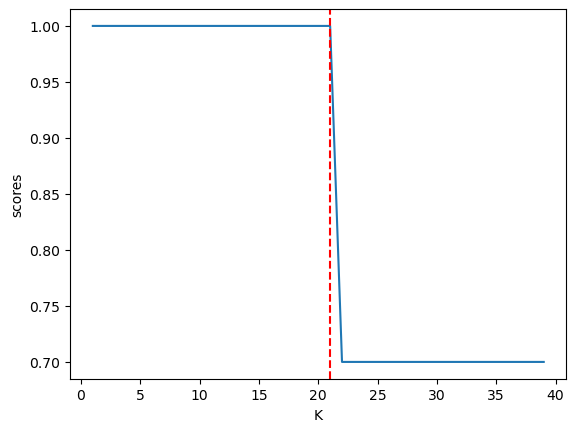

In [117]:
plt.plot(range(1, 40), scores)
plt.xlabel("K")
plt.ylabel("scores")
plt.axvline(points[0]-1, 0.0, 1.0, color='red', linestyle = 'dashed')
plt.show()

[6] 예측 하기 ==> 학습/훈련과 테스트에 사용되지 않은 데이터 사용
- 주의 : 입력 데이터 ==> 2D

In [107]:
new_data = pd.DataFrame([[413, 27.8]], columns=['Weight', 'Length'])
new_data

,Weight,Length
0,413,27.8


In [108]:
new_data_scaled = mmScaler.transform(new_data)
new_data_scaled 

array([[0.40904057, 0.57692308]])

In [109]:
# 임의의 새로운 데이터의 예측
model.predict(new_data_scaled)

array([0], dtype=int64)

In [110]:
#### 최근접한 k개 데이터 찾기
distance, index = model.kneighbors(new_data_scaled)

In [111]:
neighbors = index.reshape(-1).tolist()
neighbors

[25,
 22,
 21,
 0,
 6,
 17,
 29,
 10,
 2,
 36,
 12,
 37,
 33,
 30,
 23,
 31,
 11,
 9,
 14,
 24,
 26,
 16,
 5,
 35,
 3,
 20,
 18,
 4,
 1,
 27,
 7,
 28,
 15,
 19,
 13,
 38,
 32,
 34,
 8]

In [112]:
k_weight = X_train_scaled[neighbors][:,0]
k_length = X_train_scaled[neighbors][:,1]

print(k_weight, k_length, sep='\n')

[4.26155240e-01 3.58703312e-01 4.46290144e-01 3.85885432e-01
 4.46290144e-01 3.35548173e-01 4.96627404e-01 4.71458774e-01
 2.85210913e-01 4.96627404e-01 4.96627404e-01 3.35548173e-01
 5.97301923e-01 5.72133293e-01 6.07369375e-01 6.17436827e-01
 6.47639183e-01 6.97976442e-01 6.82875264e-01 6.77841538e-01
 6.97976442e-01 7.18111346e-01 1.32890365e-02 9.19460385e-01
 5.53709856e-03 6.74519279e-03 9.24494111e-01 9.54696466e-01
 3.12091010e-03 3.22158462e-03 1.00000000e+00 2.01349039e-03
 3.12091010e-03 3.02023558e-03 3.02023558e-04 9.49662740e-01
 8.05396154e-04 9.74831370e-01 0.00000000e+00]
[0.61538462 0.61538462 0.63782051 0.6474359  0.6474359  0.53525641
 0.63782051 0.67948718 0.52884615 0.67948718 0.69551282 0.71153846
 0.71153846 0.77564103 0.75961538 0.79166667 0.75961538 0.74358974
 0.77564103 0.80769231 0.80769231 0.80769231 0.16666667 0.91987179
 0.1025641  0.08333333 0.95192308 0.91987179 0.07051282 0.06410256
 0.87179487 0.04807692 0.04487179 0.03846154 0.02564103 1.
 0.0224359

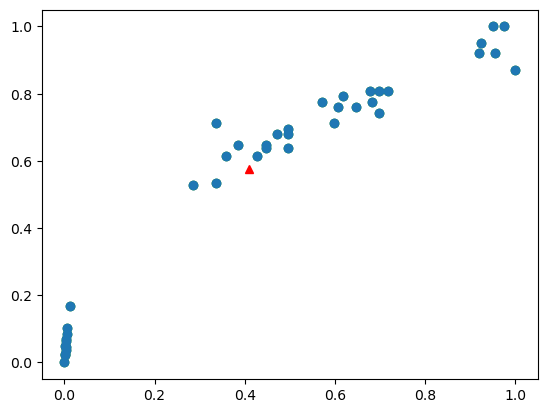

In [113]:
### 시각화로 확인
# 도미(bream), 빙어(smelt)에 대한 상관계수 ==> 2개 피쳐 Weight, Length로 Bream, Smelt 분류 가능함
plt.scatter(X_train_scaled[:,0], X_train_scaled[:,1], color = 'green') # bream
#plt.scatter(twoDF.loc[35:, 'Weight'], twoDF.loc[35:,'Length']) # smelt
plt.plot(new_data_scaled[0][0],new_data_scaled[0,1], 'r^')
plt.scatter(k_weight, k_length)
plt.show()

In [114]:
new_data_scaled[0]

array([0.40904057, 0.57692308])